# TO DO
- MORE Visualizations : Choosing the number of topics, results graph...
- Where to include optimal number of topics, coherence, perplexity y unique words?
- Interpretation of Lambda (l)
- Intepretation of perplexity and sparsity and loglikelihood (include formulas)
- Choosing the best model (grid search based on loglikelihood?)
- Give each topic a "name"
- Add coherence to the metrics????
- 'make pretty'

# LDA analysis

In [19]:
# Import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=5, suppress=True)
import pandas as pd
# data: 20 news groups

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer 
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
import random
from sklearn.feature_extraction.text import CountVectorizer

from tqdm import tqdm
import pyLDAvis.sklearn
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
pyLDAvis.enable_notebook()

[nltk_data] Downloading package punkt to /Users/ribarragi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ribarragi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ribarragi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/ribarragi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ribarragi/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Data preprocessing

In [2]:
# Read in data
df = pd.read_csv('../data/data_tweet.csv')

# RIG (made some changes to stopwords)
# modify default stop words
add_stopwords = set(['rt','train','southern','east','derailment','norfolk','palestine','february','u','ohio', 'amp', '20', 'car', ])
remove_stopwords = set(["no", "not", "nor", "against", "aren't", "couldn't", "didn't", 
                                                   "doesn't", "don't", "haven't", "hadn't", "hasn't", "isn't", "mightn't",
                                                   "mustn't", "needn't", "shouldn't", "wasn't", "weren't", "wouldn't"])
# remove stopwords (not impacting sentiment analysis) and punctuations
stop_words = set(stopwords.words('english')) - remove_stopwords
stop_words = set(stopwords.words('english')).union(add_stopwords)
# stop_words = set(stopwords.words('english')).union(add_stopwords_2)
tokenizer = RegexpTokenizer(r'\w+')


# normalize pos tags
lemmatizer = WordNetLemmatizer()

def pos_tagger(nltk_tag):
  if nltk_tag.startswith('J'):
      return wordnet.ADJ
  elif nltk_tag.startswith('V'):
      return wordnet.VERB
  elif nltk_tag.startswith('N'):
      return wordnet.NOUN
  elif nltk_tag.startswith('R'):
      return wordnet.ADV
  else:         
      return None

# lemmatize each token with pos tag
def lemma_token(row):
  wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), row))
  lemmatized = []
  for word, tag in wordnet_tagged:
    if tag is None:
        # if there is no available tag, just append the original token
        lemmatized.append(word)
    else:       
        # else use the pos tag to lemmatize the token
        lemmatized.append(lemmatizer.lemmatize(word, tag))
  return lemmatized


# RIG (edit: added http://)
# remove urls
df['Message_no_url'] = df['MESSAGE'].apply(lambda x: " ".join([word for word in x.split(" ") if not(word.startswith(("https://", 'http://')))]))


# tokenize MESSAGE and remove stopwords
df['Text'] = df['Message_no_url'].map(tokenizer.tokenize)
df['Text'] = df['Text'].apply(lambda x : nltk.pos_tag([item.lower() for item in x if item.lower() not in stop_words]))

# apply lemmatization and reset index
df['Text'] = df['Text'].apply(lambda row : lemma_token(row))
df = df.reset_index(drop=True)

# join words
df['T_text'] = df['Text'].apply(lambda row : " ".join(row))

In [4]:
# number of documents (tweets) in our data
len(df)

85220

In [5]:
# # We first used a random sample to test this
# sample_size = 10000
# random.seed(1)
# # We will use a random sample of 10k tweets to test
# idx_sample = random.sample(range(len(df.T_text)), sample_size)
# # sample_data is a list of strings, each string is a tweet. ssample_Data is length 10k
# sample_data = [df.T_text[i] for i in idx_sample]
# len(sample_data)

In [6]:
# take only the text
sample_data = df.T_text.tolist()

## Vectorization

We use CountVectorizer to get term frequencies.

In [7]:
# We could cap the size of the vocab to vocab_size
# If not capped, we have 48k words
max_vocabulary = 15000

# We can also set options to only keep words that appear in at least this percentage of documents
# - min_df = 2 # words in less than 2 documents we discard them
# And we can choose to only keep words that appear in at most this percentage of documents:
# - max_df = 0.95 # words that appear in more than 95% of documents, we discard them
# Finally, we can set max_features, to keep only the most frequently occuring words
# - max_features = max_vocabulary # after I do the max_df, min_df and stopwords filetrs, I look at how many words I have left: if its greater than
# max_features, I only keep the most popular. BUT, if the words left after the 3 filters is less than max_features, then it will be ignored. 


# tf_vectorizer = CountVectorizer(max_df=0.95,
#                                 min_df=2,
#                                 stop_words='english',
#                                 max_features=max_vocabulary)

# tf_vectorizer = CountVectorizer(stop_words='english')

# We capped the number of words to 15k and the min doc frequency
tf_vectorizer = CountVectorizer(min_df = 2, max_features=max_vocabulary)

# tf: term frequency vectorizer

# the fitting is learning the vocabulary: goes thru all the data and know the words it needs to keep track of
# transform: Ive done the fitting, Ill go back to data points and convert each one into a feat vector representation using the vocab i learnt during fitting
tf_fit = tf_vectorizer.fit(sample_data)
tf = tf_vectorizer.fit_transform(sample_data)


In [8]:
# size of the matrix (documents, words)
tf.toarray().shape

(85220, 15000)

In [9]:
# seems like the highest term-doc freq is 10
max_freq = tf.toarray().max()
max_freq

10

In [10]:
# which doc / word combination has highest values?
max_freq_idx = list(np.argwhere(tf.toarray()==max_freq)[0])
max_freq_doc, max_freq_word = max_freq_idx
# to print out the vocabulary in the doc-word freq matrix
tf_vectorizer.get_feature_names_out()[max_freq_word]
# In which document is this word?
sample_data[max_freq_doc]

'trump state go trump trump trump trump trump trump trump trump trump'

In [11]:
tf[0].toarray()

# I can index in to the zeroeth row of the matrix and convert into an array, I am anazlizing just the zeroeth row:
# feature vector representation for the zeroeth document: 
# We should be able to write code to know what word corresponds each non zero number there

# tf_vectorizer.get_feature_names_out()[(tf[0].toarray() != 0)[0]] # LIKE THIS!

# run a for loop that goes thru the entries, and check to which indeces this corresponds in the vocabulary

array([[0, 0, 0, ..., 0, 0, 0]])

The fitting procedure determines the every topic's distribution over words; this information is stored in the `components_` attribute. There's a catch: we actually have to normalize to get the probability distributions (without this normalization, instead what the model has are pseudocounts for how often different words appear per topic).

We now fit an LDA model to the data.

In [12]:
# Now LDA. This will take a while ong

num_topics = 4

lda = LatentDirichletAllocation(n_components=num_topics, random_state=0)
lda.fit(tf)

LatentDirichletAllocation(n_components=4, random_state=0)

In [13]:
lda.components_.shape
# The shaope of this is 16 by 1000, 10 topics and 1000 words
# These are not probability distributions yet

(4, 15000)

In [14]:
lda.components_  

array([[  0.27365, 233.02054,   0.25006, ...,  11.21699,  11.21699,
         11.21699],
       [ 28.10881,  37.82829,   0.35485, ...,   0.25004,   0.25004,
          0.25004],
       [  6.47948, 464.91625,   0.26389, ...,   0.25257,   0.25257,
          0.25257],
       [ 59.13806, 625.23493,   6.1312 , ...,   0.2804 ,   0.2804 ,
          0.2804 ]])

In [15]:
# If we access: sum ACROSS COLUMNS (get rid of columns), I get 6 numbers: a sum for each row.
# They dont sum uop to 1, because not probability distributions

# .components_ is a raw count histogram, but why are there fractions?
# Because of how it works: when it estimates how much a word belongs to a topic it does a prob assignment, not a deterministic assignment.
lda.components_.sum(axis=1)

array([346374.64316, 243854.68968, 267914.26725, 179606.3999 ])

In [16]:
topic_word_distributions = np.array([row / row.sum() for row in lda.components_])

# we get the topic-word distribution matrix for the LDA model.  Each value represents the probability of each word occuring in that topic. 
# The higher the value of a word in a topic, the more strongly the word is associated with that topic

In [17]:
topic_word_distributions.shape

(4, 15000)

In [18]:
print(topic_word_distributions[0])
# lets look at 0th topic, it is saying that the 0th word appears 0.00006, word 1 appears with prob 0.00121

[0.      0.00067 0.      ... 0.00003 0.00003 0.00003]


In [19]:
# # we can sort the probability by big to small
# # for each topic, listing top 20 most popular words (by probability)

# num_top_words = 20

# def print_top_words(topic_word_distributions, num_top_words, vectorizer):
#     vocab = vectorizer.get_feature_names_out()
#     num_topics = len(topic_word_distributions)
#     print('Displaying the top %d words per topic and their probabilities within the topic...' % num_top_words)
#     print()

#     for topic_idx in range(num_topics):
#         print('[Topic ', topic_idx, ']', sep='')
#         # This is the interesting part: take the topic_word_distributions only for the topic_idxth topic, and get the indexes sorted from highest to lowest
#         sort_indices = np.argsort(-topic_word_distributions[topic_idx])
#         # then for the range 0,num_words, print the vocab of each of the words and its entry in the topic_word_distribution matrix
#         for rank in range(num_top_words):
#             word_idx = sort_indices[rank]
#             print(vocab[word_idx], ':',
#                   topic_word_distributions[topic_idx, word_idx])
#         print()

# print_top_words(topic_word_distributions, num_top_words, tf_vectorizer)

In [20]:
pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)

/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.134764  0.185574       1        1  33.343986
2     -0.067166 -0.134981       2        1  25.714547
1     -0.075923 -0.084799       3        1  23.515017
3      0.277853  0.034206       4        1  17.426450, topic_info=           Term          Freq         Total Category  logprob  loglift
1124    another   5782.000000   5782.000000  Default  30.0000  30.0000
2437        ceo   4917.000000   4917.000000  Default  29.0000  29.0000
3797     derail   8824.000000   8824.000000  Default  28.0000  28.0000
3810    derails   4289.000000   4289.000000  Default  27.0000  27.0000
13498     toxic  10461.000000  10461.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
9351   official   1282.565328   3199.656576   Topic4  -4.9342   0.8330
1930      break   1106.003223   2164.302785   Topic4  -5.0823   1.0758
8930       near   1052.609101   2147.261108   Topic4  -5.1318   1.0343
8997       news   1126.596367   3459.071855   Topic4  -5.0639   0.6254
10671  railroad   1059.438283   3531.175650   Topic4  -5.1253   0.5433

[320 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
180        1  0.997319            2018
196        4  0.998637             212
590        4  0.997562          aboard
681        2  0.997978        activist
728        1  0.769391  administration
...      ...       ...             ...
14781      4  0.002390           wrong
14882      1  0.831138            year
14882      2  0.118218            year
14882      3  0.050591            year
14882      4  0.000516            year

[644 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4])

In [21]:
# We want to know, for each tweet, what fraction is explained by each of the topics
doc_topic_matrix = lda.transform(tf)
# Ill get a low dimensional version of the data, the document topic matrix (10, 10)
# each of the 10,000 represented as a distribution over 10 different topics

In [22]:
doc_topic_matrix.shape

(85220, 4)

In [23]:
sample_data[3]

'nicksortor break state sue explosion aim force railroad pay environmental cleanup economic damage'

In [24]:
df.MESSAGE.iloc[3]

'RT @nicksortor 🚨 #BREAKING: The State of Ohio is SUING Norfolk Southern over the East Palestine train explosion, aiming to FORCE the railroad to pay for environmental cleanup and economic damage.'

In [25]:
# The topic distribution of the 0th document is very small except for 0.96288 fior index 7
# We saw from above, topic 7 is about religion, and we can check that document 0 is about religion
doc_topic_matrix[0]

# Note: for GMM when you do the .predict, itll give you k probabilites that sum to 1. 
# predict_proba of GMM 
# here: ... gives you a proba distr:
# INTERPRETARATION DIFFERENT

# FOR LDA: document can consist of a bunch of words, and different fraction of the words are truly in different topics: we get mixed membership, words are allowed to e in different topics
# GMM: the above doesnt hold

array([0.94948, 0.01695, 0.01679, 0.01678])

In [26]:
# here we can take some tweets and say:this is the topic it belongs to...

In [27]:
doc_topic_matrix[0].sum()

1.0

## Split: media, public, govt

### To do
Present these results and then tweak:
- Adjust count vectorizer parameters to get better sparsity (0.2-0.8)

In [3]:
data_media = df.query('IS_MEDIA == 1')
data_govt = df.query('IS_GOVT == 1')
data_people = df.query('IS_PEOPLE == 1')

In [4]:
def parse_lda(dataframe, max_voc, min_df, num_topics):
  '''Outputs...
  Parameters: 
    list_documents:list of strings, contains documents to be analyzed
    max_voc:int, the max size of vocab allowed
    min_df: int, minimum document frequency, i.e., keep words that appear in at least this number of documents
    '''
  sample_data = dataframe.T_text.tolist()
  max_vocabulary = max_voc
  tf_vectorizer = CountVectorizer(min_df = min_df, max_features=max_voc)
  tf_fit = tf_vectorizer.fit(sample_data)
  tf = tf_vectorizer.fit_transform(sample_data)
  lda = LatentDirichletAllocation(n_components=num_topics, random_state=0)
  lda.fit(tf)

  return tf, tf_vectorizer, tf_vectorizer.get_feature_names_out(), lda, sample_data

In [54]:
# we are getting the term frequency, ..., the vocabulary ordered alphabetically, fitted lda and the data used.
tf, tf_vectorizer, vocab, lda, data = parse_lda(data_media, max_voc = 3800, min_df = 2, num_topics = 4)

In [6]:
print(f'Size of the ... (tweets, words in vocabulary): {tf.toarray().shape}')

Size of the ... (tweets, words in vocabulary): (7406, 3800)


In [7]:
# Metrics part 1

# 1. Sparsity
# How sparse is this document?
# We are taking the non zero entries in the doc-word frequency matrix
# Sparsity (%) = (# of zero elements in tf / total # of elements in tf) x 100

sparsity_media = ((tf.todense() > 0).sum() / tf.todense().size)*100
print(f'Sparsity: {sparsity_media}')


#LOOK: to icnrease sparsity, we can increase min_df (can be integer or float)
# we can also lower max_features
# we can also reduce stop words

Sparsity: 0.2962036471140043


In [8]:
def most_frequent(tf, vocab, data):
  #highest frequency word
  max_freq = tf.toarray().max()
  # which doc / word combination has highest values?
  max_freq_idx = list(np.argwhere(tf.toarray()==max_freq)[0])
  max_freq_doc, max_freq_word = max_freq_idx
  # to print out the vocabulary in the doc-word freq matrix
  # vocab[max_freq_word]
  # In which document is this word?
  # sample_data[max_freq_doc]
  print(f'The most repeated word in a single tweet is {vocab[max_freq_word]}, and it is repeated {max_freq} times in the tweet: {data[max_freq_doc]}')
  

In [55]:
most_frequent(tf, vocab, data)

The most repeated word in a single tweet is get, and it is repeated 4 times in the tweet: get rid safety rule get get rid bank safety rule get svb signature


In [56]:
topic_word = np.array([row / row.sum() for row in lda.components_])

In [57]:
topic_word.shape


(4, 3800)

## Media

In [58]:
pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.140535  0.141688       1        1  27.896109
2     -0.215155  0.012501       2        1  24.851358
1      0.088419 -0.189303       3        1  24.242818
3     -0.013800  0.035114       4        1  23.009715, topic_info=          Term        Freq       Total Category  logprob  loglift
1004    derail  814.000000  814.000000  Default  30.0000  30.0000
1235       epa  471.000000  471.000000  Default  29.0000  29.0000
613        ceo  648.000000  648.000000  Default  28.0000  28.0000
574        car  377.000000  377.000000  Default  27.0000  27.0000
3019    senate  333.000000  333.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
1442    follow  120.901956  330.832696   Topic4  -5.0890   0.4626
3218     state  110.494202  330.944457   Topic4  -5.1790   0.3723
3457      town  102.648044  281.911931   Topic4  -5.2527   0.4590
2019      live   97.326737  246.508437   Topic4  -5.3059   0.5399
2748  railroad   93.614802  400.291235   Topic4  -5.3448   0.0162

[270 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
28        2  0.933870      2012
39        2  0.962558       212
129       2  0.979476    aboard
139       1  0.615888  accident
139       2  0.256620  accident
...     ...       ...       ...
3751      1  0.864843    worker
3751      2  0.015869    worker
3751      3  0.071409    worker
3751      4  0.047606    worker
3788      4  0.979782      yost

[456 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4])

In [13]:
def tweet_topic(dataframe, lda, tf, tweet_no):
  tweet_topic_matrix = lda.transform(tf)
  print(f'{dataframe.MESSAGE.iloc[tweet_no]}')
  print(f'{tweet_topic_matrix[tweet_no]}')

In [14]:
tweet_topic(data_media, lda, tf, 14)

Ohio filed a lawsuit against railroad Norfolk Southern to make sure it pays for the cleanup and environmental damage caused by a fiery train derailment last month. https://t.co/2iybJ3ySje
[0.01803 0.01838 0.94527 0.01832]


In [15]:
# Metrics part 2


# 2. Loglikelihood
loglikelihood_media = lda.score(tf)
perplexity_media = lda.perplexity(tf)

print(f'Loglikelihood: {loglikelihood_media}')
print(f'Perplexity: {perplexity_media}')

# INTERPRETATION MISSING



Loglikelihood: -596634.0540684959
Perplexity: 1095.9522157406354


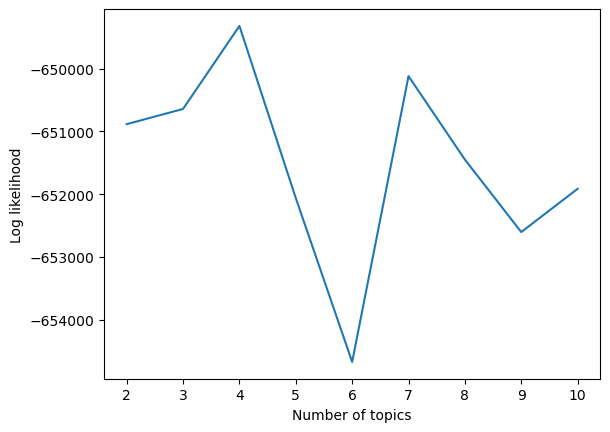

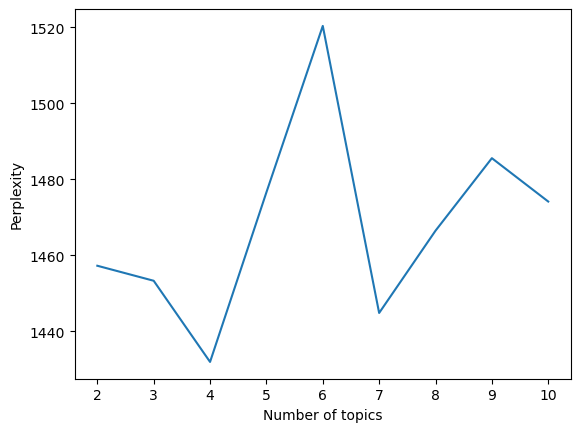

In [59]:
import matplotlib.pyplot as plt

k = 10

text = [i for i in data_media.T_text]

# Tokenize on bigrams
trigram_tfvectorizer = CountVectorizer(tokenizer=lambda doc: nltk.ngrams(nltk.word_tokenize(doc.lower()), 1))
trigram_tf = trigram_tfvectorizer.fit_transform(text)

loglikelihoods = []
perplexities = []

for k in range(2, k+1):
    lda_model = LatentDirichletAllocation(n_components=k)
    lda_model.fit(trigram_tf)
    pipeline = make_pipeline(trigram_tfvectorizer, lda_model)
    loglikelihood_people = lda_model.score(trigram_tf)
    loglikelihoods.append(loglikelihood_people)
    perplexity_people = lda_model.perplexity(trigram_tf)
    perplexities.append(perplexity_people)

# Plot
plt.plot(range(2, k+1), loglikelihoods)
plt.xlabel('Number of topics')
plt.ylabel('Log likelihood')
plt.xticks(range(2, k + 1))
# plt.title('Coherence')
plt.show()

plt.plot(range(2, k+1), perplexities)
plt.xlabel('Number of topics')
plt.ylabel('Perplexity')
plt.xticks(range(2, k + 1))
plt.show()

## GOVT


In [42]:
tf, tf_vectorizer, vocab, lda, data = parse_lda(data_govt, max_voc = 800, min_df = 2, num_topics = 4)

In [43]:
print(f'Size of the ... (tweets, words in vocabulary): {tf.toarray().shape}')

Size of the ... (tweets, words in vocabulary): (376, 800)


In [44]:
# Metrics part 1

# 1. Sparsity
# How sparse is this document?
# We are taking the non zero entries in the doc-word frequency matrix
# Sparsity (%) = (# of zero elements in tf / total # of elements in tf) x 100

sparsity_govt = ((tf.todense() > 0).sum() / tf.todense().size)*100
print(f'Sparsity: {sparsity_govt}')


#OJO: to icnrease sparsity, we can increase min_df (can be integer or float)
# we can also lower max_features
# we can also reduce stop words

Sparsity: 1.496343085106383


In [45]:
most_frequent(tf, vocab, data)

The most repeated word in a single tweet is update, and it is repeated 3 times in the tweet: update ohioag file civil lawsuit united state district court northern district today full update previous update information


topic_word = np.array([row / row.sum() for row in lda.components_])
topic_word.shape


## Govt

In [46]:

pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)

/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.170657  0.033462       1        1  28.965267
1     -0.047701 -0.130685       2        1  25.996674
3     -0.103835  0.119053       3        1  23.574376
0     -0.019120 -0.021830       4        1  21.463684, topic_info=          Term       Freq      Total Category  logprob  loglift
744     update  24.000000  24.000000  Default  30.0000  30.0000
127        ceo  29.000000  29.000000  Default  29.0000  29.0000
502     people  26.000000  26.000000  Default  28.0000  28.0000
258        epa  34.000000  34.000000  Default  27.0000  27.0000
154  community  28.000000  28.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
773       week   6.083698  18.743672   Topic4  -5.1088   0.4136
689       take   6.457287  23.089527   Topic4  -5.0492   0.2646
762      visit   5.969723  18.877453   Topic4  -5.1277   0.3875
502     people   6.226993  26.515297   Topic4  -5.0855   0.0900
554       rail   6.312600  41.908917   Topic4  -5.0718  -0.3541

[274 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1         2  0.729539     000
1         4  0.145908     000
14        1  0.926150      24
16        4  0.788530     25k
21        4  0.788530     6am
...     ...       ...     ...
788       4  0.234221    work
789       1  0.234910  worker
789       2  0.156606  worker
789       3  0.078303  worker
789       4  0.469819  worker

[384 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 4, 1])

In [47]:
tweet_topic(data_govt, lda, tf, 14)

The disaster in East Palestine clearly demonstrates the need for more federal oversight on rail and transportation companies. Our economy depends on infrastructure and railways, and it is in the best interest of all of us to have safe and reliable service. https://t.co/I5xnAn87k2
[0.01898 0.01955 0.01817 0.94329]


In [48]:
# Metrics part 2


# 2. Loglikelihood
loglikelihood_govt = lda.score(tf)
loglikelihood_govt = lda.perplexity(tf)

print(f'Loglikelihood: {loglikelihood_govt}')
print(f'Perplexity: {loglikelihood_govt}')

# INTERPRETATION MISSING


Loglikelihood: 771.9467568087389
Perplexity: 771.9467568087389


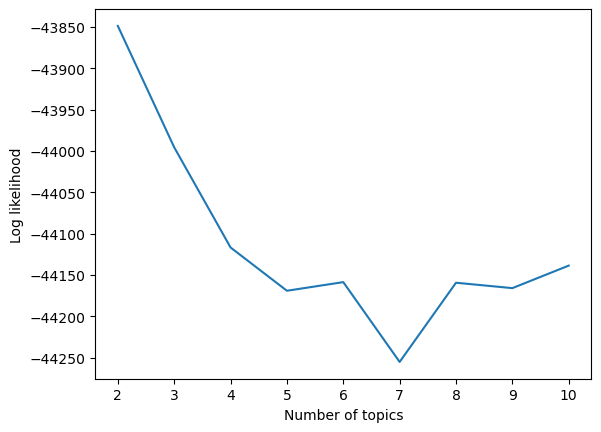

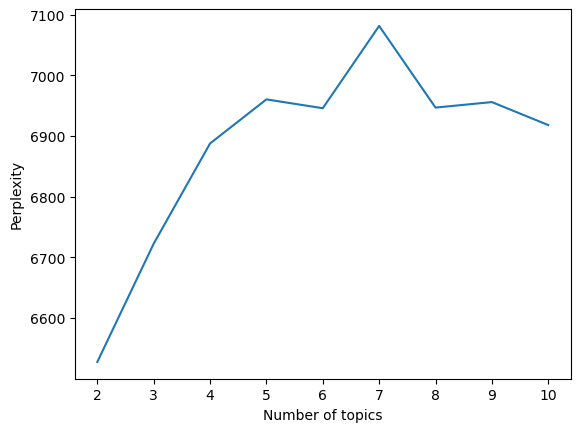

In [62]:
import matplotlib.pyplot as plt

k = 10

text = [i for i in data_govt.T_text]

# Tokenize on bigrams
trigram_tfvectorizer = CountVectorizer(tokenizer=lambda doc: nltk.ngrams(nltk.word_tokenize(doc.lower()), 3))
trigram_tf = trigram_tfvectorizer.fit_transform(text)

loglikelihoods = []
perplexities = []

for k in range(2, k+1):
    lda_model = LatentDirichletAllocation(n_components=k)
    lda_model.fit(trigram_tf)
    pipeline = make_pipeline(trigram_tfvectorizer, lda_model)
    loglikelihood_people = lda_model.score(trigram_tf)
    loglikelihoods.append(loglikelihood_people)
    perplexity_people = lda_model.perplexity(trigram_tf)
    perplexities.append(perplexity_people)

# Plot
plt.plot(range(2, k+1), loglikelihoods)
plt.xlabel('Number of topics')
plt.ylabel('Log likelihood')
plt.xticks(range(2, k + 1))
# plt.title('Coherence')
plt.show()

plt.plot(range(2, k+1), perplexities)
plt.xlabel('Number of topics')
plt.ylabel('Perplexity')
plt.xticks(range(2, k + 1))
plt.show()

## People

In [49]:
tf, tf_vectorizer, vocab, lda, data = parse_lda(data_people, 12000, 2, num_topics = 4)

In [50]:
print(f'Size of the ... (tweets, words in vocabulary): {tf.toarray().shape}')

Size of the ... (tweets, words in vocabulary): (77438, 12000)


In [51]:
# Metrics part 1

# 1. Sparsity
# How sparse is this document?
# We are taking the non zero entries in the doc-word frequency matrix
# Sparsity (%) = (# of zero elements in tf / total # of elements in tf) x 100

sparsity_people = ((tf.todense() > 0).sum() / tf.todense().size)*100
print(f'Sparsity: {sparsity_people}')


#OJO: to icnrease sparsity, we can increase min_df (can be integer or float)
# we can also lower max_features
# we can also reduce stop words

Sparsity: 0.09560487099356904


In [52]:
most_frequent(tf, vocab, data)

The most repeated word in a single tweet is trump, and it is repeated 10 times in the tweet: trump state go trump trump trump trump trump trump trump trump trump


In [53]:
topic_word = np.array([row / row.sum() for row in lda.components_])
topic_word.shape

(4, 12000)

In [54]:
#12000
pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)

/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.017246 -0.146793       1        1  27.585066
3     -0.183883 -0.057026       2        1  26.817203
0      0.212621  0.005482       3        1  24.086648
1     -0.045983  0.198337       4        1  21.511083, topic_info=            Term         Freq        Total Category  logprob  loglift
10967      trump  8062.000000  8062.000000  Default  30.0000  30.0000
9259      safety  5710.000000  5710.000000  Default  29.0000  29.0000
11434      visit  3190.000000  3190.000000  Default  28.0000  28.0000
1338       biden  5298.000000  5298.000000  Default  27.0000  27.0000
1724   buttigieg  2973.000000  2973.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
11380        via  1230.090654  4603.090295   Topic4  -5.0823   0.2170
6509        make  1042.153879  2920.471845   Topic4  -5.2481   0.5061
2024    chemical  1430.714976  7875.235273   Topic4  -4.9312  -0.1689
1770        call   855.048764  1990.380441   Topic4  -5.4459   0.6917
2617       crash   860.584058  2934.957468   Topic4  -5.4395   0.3098

[322 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
158        1  0.994828             212
192        1  0.993232              28
254        3  0.995621              43
560        1  0.000576  administration
560        2  0.414368  administration
...      ...       ...             ...
11912      1  0.413335            year
11912      2  0.527626            year
11912      3  0.036063            year
11912      4  0.022747            year
11928      4  0.991174            yost

[613 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 2])

In [55]:
#15000
# pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)

In [56]:
tweet_topic(data_people, lda, tf, 14)

RT @ACTBrigitte Immediately after the train crashed in East Palestine, the Democrats blamed President Trump. 2 weeks later the Washington Post fact checkers found that President Trump's changes had nothing to do with the crash. The Silicon Valley Bank just collapsed and the Democrats are…
[0.01024 0.96866 0.01033 0.01076]


In [213]:
# Metrics part 2


# 2. Loglikelihood
loglikelihood_people = lda.score(tf)
perplexity_people = lda.perplexity(tf)

print(f'Loglikelihood: {loglikelihood_people}')
print(f'Perplexity: {perplexity_people}')

# INTERPRETATION MISSING

Loglikelihood: -6901292.724032542
Perplexity: 1745.8362936854046


100%|██████████| 9/9 [06:18<00:00, 42.07s/it]


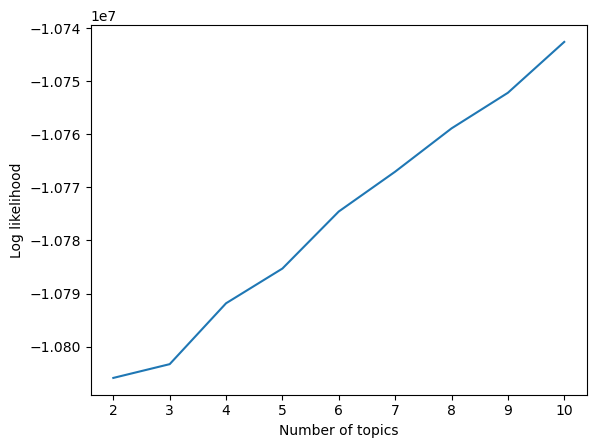

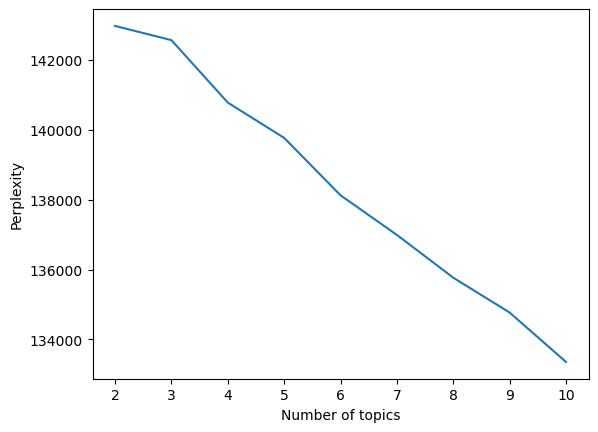

In [70]:
import matplotlib.pyplot as plt
from tqdm import tqdm

k = 10

text = [i for i in data_people.T_text]

# Tokenize on bigrams
trigram_tfvectorizer = CountVectorizer(tokenizer=lambda doc: nltk.ngrams(nltk.word_tokenize(doc.lower()), 2))
trigram_tf = trigram_tfvectorizer.fit_transform(text)

loglikelihoods = []
perplexities = []

for k in tqdm(range(2, k+1)):
    lda_model = LatentDirichletAllocation(n_components=k)
    lda_model.fit(trigram_tf)
    pipeline = make_pipeline(trigram_tfvectorizer, lda_model)
    loglikelihood_people = lda_model.score(trigram_tf)
    loglikelihoods.append(loglikelihood_people)
    perplexity_people = lda_model.perplexity(trigram_tf)
    perplexities.append(perplexity_people)

# Plot
plt.plot(range(2, k+1), loglikelihoods)
plt.xlabel('Number of topics')
plt.ylabel('Log likelihood')
plt.xticks(range(2, k + 1))
# plt.title('Coherence')
plt.show()

plt.plot(range(2, k+1), perplexities)
plt.xlabel('Number of topics')
plt.ylabel('Perplexity')
plt.xticks(range(2, k + 1))
plt.show()

100%|██████████| 11/11 [07:46<00:00, 42.44s/it]


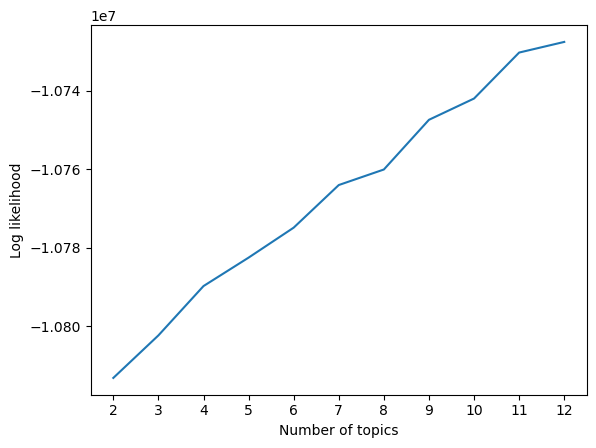

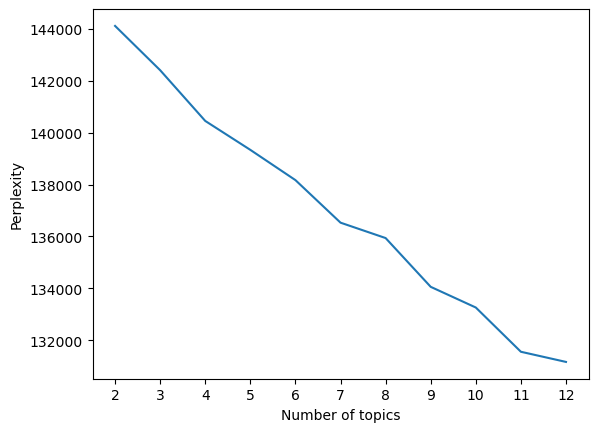

In [115]:
import matplotlib.pyplot as plt
from tqdm import tqdm

k = 12

text = [i for i in data_people.T_text]

# Tokenize on bigrams
trigram_tfvectorizer = CountVectorizer(tokenizer=lambda doc: nltk.ngrams(nltk.word_tokenize(doc.lower()), 2))
trigram_tf = trigram_tfvectorizer.fit_transform(text)

loglikelihoods = []
perplexities = []

for k in tqdm(range(2, k+1)):
    lda_model = LatentDirichletAllocation(n_components=k)
    lda_model.fit(trigram_tf)
    pipeline = make_pipeline(trigram_tfvectorizer, lda_model)
    loglikelihood_people = lda_model.score(trigram_tf)
    loglikelihoods.append(loglikelihood_people)
    perplexity_people = lda_model.perplexity(trigram_tf)
    perplexities.append(perplexity_people)

# Plot
plt.plot(range(2, k+1), loglikelihoods)
plt.xlabel('Number of topics')
plt.ylabel('Log likelihood')
plt.xticks(range(2, k + 1))
# plt.title('Coherence')
plt.show()

plt.plot(range(2, k+1), perplexities)
plt.xlabel('Number of topics')
plt.ylabel('Perplexity')
plt.xticks(range(2, k + 1))
plt.show()

## Now, lets use trigrams, start with media data and the 4 recommended topics

In [73]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk

# Sample text
text = [i for i in data_media.T_text]

# Tokenize on bigrams
bigram = CountVectorizer(tokenizer=lambda doc: nltk.ngrams(nltk.word_tokenize(doc.lower()), 2))
bigram_tokens = bigram.fit_transform(text)

# Train LDA model
lda_model = LatentDirichletAllocation(n_components=10)
lda_model.fit(bigram_tokens)

from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(bigram, lda_model)
vis_data = pyLDAvis.sklearn.prepare(lda_model, bigram_tokens, bigram)
pyLDAvis.display(vis_data)

/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/joblib

# Now govt...

In [129]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk

# Sample text
text = [i for i in data_govt.T_text]

# Tokenize on bigrams
bigram = CountVectorizer(tokenizer=lambda doc: nltk.ngrams(nltk.word_tokenize(doc.lower()), 2))
bigram_tokens = bigram.fit_transform(text)

# Train LDA model
lda_model = LatentDirichletAllocation(n_components=2)
lda_model.fit(bigram_tokens)

from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(bigram, lda_model)
vis_data = pyLDAvis.sklearn.prepare(lda_model, bigram_tokens, bigram)
pyLDAvis.display(vis_data)

In [131]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk

# Sample text
text = [i for i in data_govt.T_text]

# Tokenize on bigrams
bigram = CountVectorizer(tokenizer=lambda doc: nltk.ngrams(nltk.word_tokenize(doc.lower()), 2))
bigram_tokens = bigram.fit_transform(text)

# Train LDA model
lda_model = LatentDirichletAllocation(n_components=3)
lda_model.fit(bigram_tokens)

from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(bigram, lda_model)
vis_data = pyLDAvis.sklearn.prepare(lda_model, bigram_tokens, bigram)
pyLDAvis.display(vis_data)

In [132]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk

# Sample text
text = [i for i in data_govt.T_text]

# Tokenize on bigrams
bigram = CountVectorizer(tokenizer=lambda doc: nltk.ngrams(nltk.word_tokenize(doc.lower()), 2))
bigram_tokens = bigram.fit_transform(text)

# Train LDA model
lda_model = LatentDirichletAllocation(n_components=4)
lda_model.fit(bigram_tokens)

from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(bigram, lda_model)
vis_data = pyLDAvis.sklearn.prepare(lda_model, bigram_tokens, bigram)
pyLDAvis.display(vis_data)

# Now people

In [74]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk

# Sample text
text = [i for i in data_people.T_text]

# Tokenize on bigrams
bigram = CountVectorizer(tokenizer=lambda doc: nltk.ngrams(nltk.word_tokenize(doc.lower()), 2))
bigram_tokens = bigram.fit_transform(text)

# Train LDA model
lda_model = LatentDirichletAllocation(n_components=6)
lda_model.fit(bigram_tokens)

from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(bigram, lda_model)
vis_data = pyLDAvis.sklearn.prepare(lda_model, bigram_tokens, bigram)
pyLDAvis.display(vis_data)

/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/joblib

In [75]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk

# Sample text
text = [i for i in data_people.T_text]

# Tokenize on bigrams
bigram = CountVectorizer(tokenizer=lambda doc: nltk.ngrams(nltk.word_tokenize(doc.lower()), 2))
bigram_tokens = bigram.fit_transform(text)

# Train LDA model
lda_model = LatentDirichletAllocation(n_components=8)
lda_model.fit(bigram_tokens)

from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(bigram, lda_model)
vis_data = pyLDAvis.sklearn.prepare(lda_model, bigram_tokens, bigram)
pyLDAvis.display(vis_data)

/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/joblib

In [77]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk

# Sample text
text = [i for i in data_people.T_text]

# Tokenize on bigrams
bigram = CountVectorizer(tokenizer=lambda doc: nltk.ngrams(nltk.word_tokenize(doc.lower()), 2))
bigram_tokens = bigram.fit_transform(text)

# Train LDA model
lda_model = LatentDirichletAllocation(n_components=10)
lda_model.fit(bigram_tokens)

from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(bigram, lda_model)
vis_data = pyLDAvis.sklearn.prepare(lda_model, bigram_tokens, bigram)
pyLDAvis.display(vis_data)

/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/joblib

In [82]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk

# Sample text
text = [i for i in data_people.T_text]

# Tokenize on bigrams
bigram = CountVectorizer(tokenizer=lambda doc: nltk.ngrams(nltk.word_tokenize(doc.lower()), 2))
bigram_tokens = bigram.fit_transform(text)

# Train LDA model
lda_model = LatentDirichletAllocation(n_components=20)
lda_model.fit(bigram_tokens)

from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(bigram, lda_model)
vis_data = pyLDAvis.sklearn.prepare(lda_model, bigram_tokens, bigram)
pyLDAvis.display(vis_data)

/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/joblib

## MEDIA RESULTS

In [133]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk

# Sample text
text = [i for i in data_media.T_text]

# Tokenize on bigrams
bigram = CountVectorizer(tokenizer=lambda doc: nltk.ngrams(nltk.word_tokenize(doc.lower()), 2))
bigram_tokens = bigram.fit_transform(text)

# Train LDA model
lda_model = LatentDirichletAllocation(n_components=4)
lda_model.fit(bigram_tokens)

from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(bigram, lda_model)
vis_data = pyLDAvis.sklearn.prepare(lda_model, bigram_tokens, bigram)
pyLDAvis.display(vis_data)

/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/setupt

In [134]:
len(text)

7406

In [137]:
len(bigram.vocabulary_)

37579

In [139]:
bigram_tokens.toarray().shape


(7406, 37579)

## Compute coherence by hand

In [85]:
# COmpute coherence by hand
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk

# Sample text
text = [i for i in data_people.T_text]

# Tokenize on bigrams
bigram = CountVectorizer(tokenizer=lambda doc: nltk.ngrams(nltk.word_tokenize(doc.lower()), 2))
bigram_tokens = bigram.fit_transform(text)

# Train LDA model
lda = LatentDirichletAllocation(n_components=20)
lda.fit(bigram_tokens)

topic_word_distributions = np.array([row / row.sum() for row in lda.components_])

In [89]:
def prob_see_word1_given_see_word2(word1, word2, vectorizer, eps=0.1):
    word1_column_idx = vectorizer.vocabulary_[word1]
    word2_column_idx = vectorizer.vocabulary_[word2]
    documents_with_word1 = (bigram_tokens[:, word1_column_idx].toarray().flatten() > 0)
    documents_with_word2 = (bigram_tokens[:, word2_column_idx].toarray().flatten() > 0)
    documents_with_both_word1_and_word2 = documents_with_word1 * documents_with_word2
    return np.log2((documents_with_both_word1_and_word2.sum() + eps) / documents_with_word2.sum())

In [90]:
# topic coherence

def compute_average_coherence(topic_word_distributions, num_top_words, vectorizer, verbose=True):
    vocab = vectorizer.get_feature_names()
    num_topics = len(topic_word_distributions)
    average_coherence = 0
    # foor loop thru different topics, for each topic double nested for loop, going thru each entry, ordering matters
    # make sure words arent the same, then compute the log(prob)
    # add a bunhc of them and divide by total number of topics
    for topic_idx in range(num_topics):
        if verbose:
            print('[Topic ', topic_idx, ']', sep='')
        
        sort_indices = np.argsort(topic_word_distributions[topic_idx])[::-1]
        coherence = 0.
        for top_word_idx1 in sort_indices[:num_top_words]:
            word1 = vocab[top_word_idx1]
            for top_word_idx2 in sort_indices[:num_top_words]:
                word2 = vocab[top_word_idx2]
                if top_word_idx1 != top_word_idx2:
                    coherence += prob_see_word1_given_see_word2(word1, word2, vectorizer, 0.1)
        
        if verbose:
            print('Coherence:', coherence)
            print()
        average_coherence += coherence
    average_coherence /= num_topics
    if verbose:
        print('Average coherence:', average_coherence)
    return average_coherence

In [91]:
num_top_words = 20

compute_average_coherence(topic_word_distributions, num_top_words, bigram, True)

[Topic 0]
Coherence: -2922.0106308594573

[Topic 1]
Coherence: -2978.9465778416593

[Topic 2]
Coherence: -2939.9046595264394

[Topic 3]
Coherence: -2643.1499089303234

[Topic 4]
Coherence: -2745.367476153625

[Topic 5]
Coherence: -3188.8597727603556

[Topic 6]
Coherence: -3338.404496863443

[Topic 7]
Coherence: -3249.9847812212124

[Topic 8]
Coherence: -3197.071213700179

[Topic 9]
Coherence: -3108.165170354932

[Topic 10]
Coherence: -2885.6762377064733

[Topic 11]
Coherence: -3224.0846788881654

[Topic 12]
Coherence: -3108.3732762438417

[Topic 13]
Coherence: -3360.1969181301474

[Topic 14]
Coherence: -3438.0816300179063

[Topic 15]
Coherence: -3332.580464049724

[Topic 16]
Coherence: -3362.7796862349023

[Topic 17]
Coherence: -3475.4651073185537

[Topic 18]
Coherence: -316.94896342105915

[Topic 19]
Coherence: -3064.4313353039233

Average coherence: -2994.0241492763166


-2994.0241492763166

In [98]:
k_values = range(2, 20)
avg_coherences = []
avg_num_unique_words = []

for k in tqdm(k_values):
    lda_candidate = LatentDirichletAllocation(n_components=k, random_state=0)
    lda_candidate.fit(bigram_tokens)
    topic_word_distributions = np.array([row / row.sum() for row in lda_candidate.components_])
    
    avg_coherences.append(compute_average_coherence(topic_word_distributions, num_top_words, bigram, False))
    avg_num_unique_words.append(compute_average_num_unique_words(topic_word_distributions, num_top_words, bigram, False))



100%|██████████| 18/18 [26:01<00:00, 86.76s/it] 


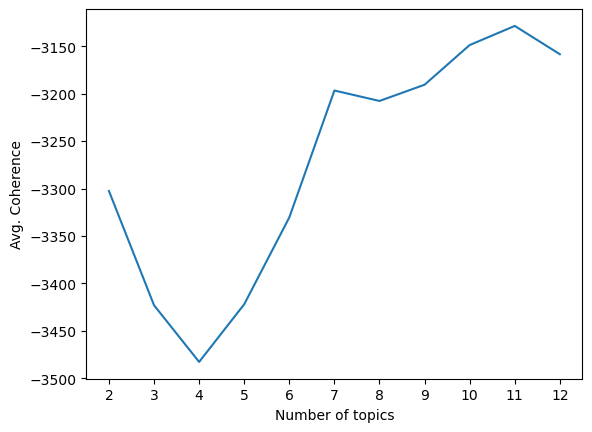

In [112]:
plt.plot(range(2, 13), avg_coherences[0:11])
plt.xlabel('Number of topics')
plt.ylabel('Avg. Coherence')
plt.xticks(range(2, 13))
plt.show()

In [118]:
avg_num_unique_words_people = avg_num_unique_words.copy()
avg_coherences_people = avg_coherences.copy()

## Coherence for media

In [119]:
# COmpute coherence by hand
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk

# Sample text
text = [i for i in data_media.T_text]

# Tokenize on bigrams
bigram = CountVectorizer(tokenizer=lambda doc: nltk.ngrams(nltk.word_tokenize(doc.lower()), 2))
bigram_tokens = bigram.fit_transform(text)

# Train LDA model
lda = LatentDirichletAllocation(n_components=20)
lda.fit(bigram_tokens)

topic_word_distributions = np.array([row / row.sum() for row in lda.components_])

In [120]:
k_values = range(2, 20)
avg_coherences = []
avg_num_unique_words = []

for k in tqdm(k_values):
    lda_candidate = LatentDirichletAllocation(n_components=k, random_state=0)
    lda_candidate.fit(bigram_tokens)
    topic_word_distributions = np.array([row / row.sum() for row in lda_candidate.components_])
    
    avg_coherences.append(compute_average_coherence(topic_word_distributions, num_top_words, bigram, False))
    avg_num_unique_words.append(compute_average_num_unique_words(topic_word_distributions, num_top_words, bigram, False))

100%|██████████| 18/18 [02:25<00:00,  8.08s/it]


In [121]:
avg_num_unique_words_media = avg_num_unique_words.copy()
avg_coherences_media = avg_coherences.copy()

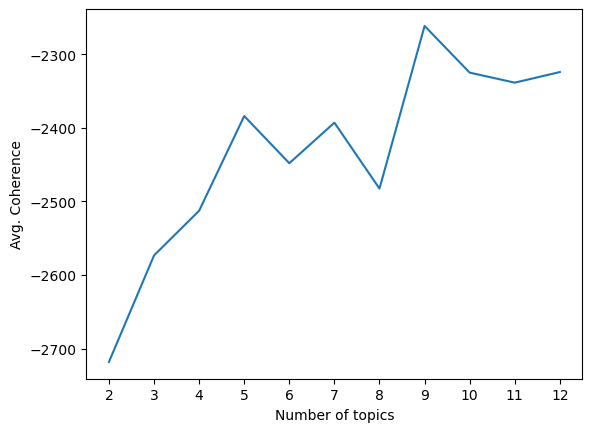

In [122]:
plt.plot(range(2, 13), avg_coherences[0:11])
plt.xlabel('Number of topics')
plt.ylabel('Avg. Coherence')
plt.xticks(range(2, 13))
plt.show()

# Coherence for govt

In [124]:
# COmpute coherence by hand
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk

# Sample text
text = [i for i in data_govt.T_text]

# Tokenize on bigrams
bigram = CountVectorizer(tokenizer=lambda doc: nltk.ngrams(nltk.word_tokenize(doc.lower()), 2))
bigram_tokens = bigram.fit_transform(text)

# Train LDA model
lda = LatentDirichletAllocation(n_components=20)
lda.fit(bigram_tokens)

topic_word_distributions = np.array([row / row.sum() for row in lda.components_])

In [125]:
k_values = range(2, 20)
avg_coherences = []
avg_num_unique_words = []

for k in tqdm(k_values):
    lda_candidate = LatentDirichletAllocation(n_components=k, random_state=0)
    lda_candidate.fit(bigram_tokens)
    topic_word_distributions = np.array([row / row.sum() for row in lda_candidate.components_])
    
    avg_coherences.append(compute_average_coherence(topic_word_distributions, num_top_words, bigram, False))
    avg_num_unique_words.append(compute_average_num_unique_words(topic_word_distributions, num_top_words, bigram, False))

100%|██████████| 18/18 [00:13<00:00,  1.31it/s]


In [126]:
avg_num_unique_words_govt = avg_num_unique_words.copy()
avg_coherences_govt = avg_coherences.copy()

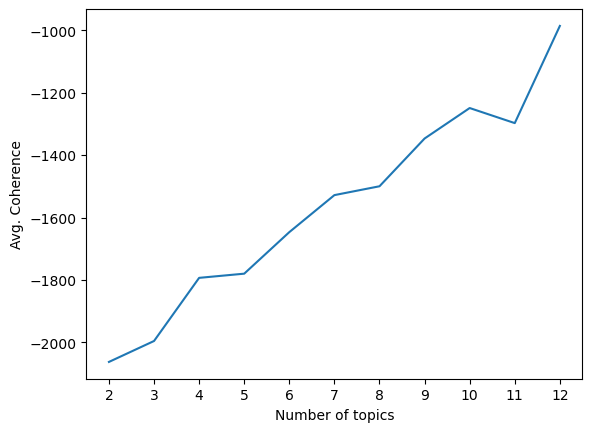

In [127]:
plt.plot(range(2, 13), avg_coherences[0:11])
plt.xlabel('Number of topics')
plt.ylabel('Avg. Coherence')
plt.xticks(range(2, 13))
plt.show()

# seems to make more sense, but now let decide on the number of topics for each: govt, media, people: coherence, perplexity, loglikelihood

In [44]:
text = [i for i in data_media.T_text]

# Tokenize on bigrams
trigram_tfvectorizer = CountVectorizer(tokenizer=lambda doc: nltk.ngrams(nltk.word_tokenize(doc.lower()), 3))
trigram_tf = trigram_tfvectorizer.fit_transform(text)

# Train LDA model
lda_model = LatentDirichletAllocation(n_components=4)
lda_model.fit(trigram_tf)

pipeline = make_pipeline(trigram_tfvectorizer, lda_model)
# pyLDAvis.sklearn.prepare(lda_model, bigram_tokens, bigram)

In [46]:
#tf
len(trigram_tfvectorizer.vocabulary_)

#tf_vectorizer
trigram_tf.toarray().shape

(7406, 45587)

In [43]:
trigram_tf

CountVectorizer(tokenizer=<function <lambda> at 0x166b8aa60>)

In [42]:
tf_vectorizer

CountVectorizer(max_features=3800, min_df=2)

In [47]:
# Metrics part 2


# 2. Loglikelihood
loglikelihood_people = lda_model.score(trigram_tf)
perplexity_people = lda_model.perplexity(trigram_tf)

print(f'Loglikelihood: {loglikelihood_people}')
print(f'Perplexity: {perplexity_people}')

# INTERPRETATION MISSING

Loglikelihood: -797643.5829323751
Perplexity: 43700.36033446216


# Now for many different themes

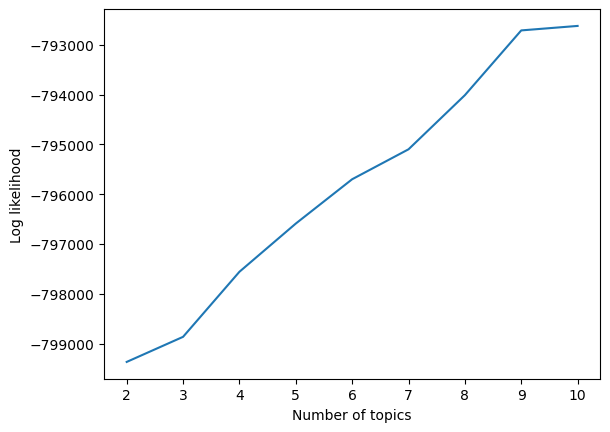

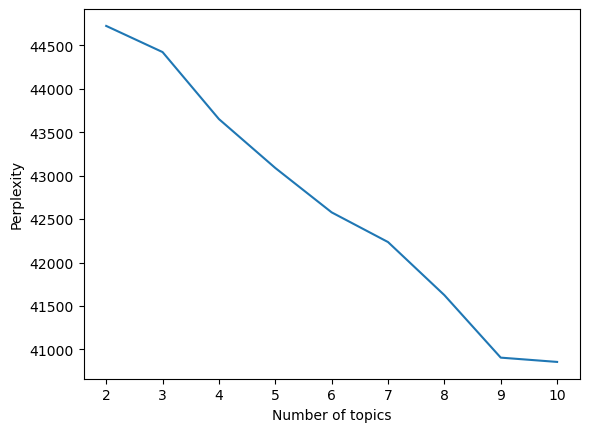

In [52]:
import matplotlib.pyplot as plt

k = 10

text = [i for i in data_media.T_text]

# Tokenize on bigrams
trigram_tfvectorizer = CountVectorizer(tokenizer=lambda doc: nltk.ngrams(nltk.word_tokenize(doc.lower()), 3))
trigram_tf = trigram_tfvectorizer.fit_transform(text)

loglikelihoods = []
perplexities = []

for k in range(2, k+1):
    lda_model = LatentDirichletAllocation(n_components=k)
    lda_model.fit(trigram_tf)
    pipeline = make_pipeline(trigram_tfvectorizer, lda_model)
    loglikelihood_people = lda_model.score(trigram_tf)
    loglikelihoods.append(loglikelihood_people)
    perplexity_people = lda_model.perplexity(trigram_tf)
    perplexities.append(perplexity_people)

# Plot
plt.plot(range(2, k+1), loglikelihoods)
plt.xlabel('Number of topics')
plt.ylabel('Log likelihood')
plt.xticks(range(2, k + 1))
# plt.title('Coherence')
plt.show()

plt.plot(range(2, k+1), perplexities)
plt.xlabel('Number of topics')
plt.ylabel('Perplexity')
plt.xticks(range(2, k + 1))
plt.show()

    

In [ ]:
def prob_see_word1_given_see_word2(word1, word2, #vectorizer#, eps=0.1):
    word1_column_idx = vectorizer.vocabulary_[word1]
    word2_column_idx = vectorizer.vocabulary_[word2]
    documents_with_word1 = (tf[:, word1_column_idx].toarray().flatten() > 0)
    documents_with_word2 = (tf[:, word2_column_idx].toarray().flatten() > 0)
    documents_with_both_word1_and_word2 = documents_with_word1 * documents_with_word2
    return np.log2((documents_with_both_word1_and_word2.sum() + eps) / documents_with_word2.sum())

In [53]:
pyLDAvis.sklearn.prepare(lda_model, trigram_tf, trigram_tfvectorizer)

/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/joblib

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.136499 -0.159740       1        1  10.682983
2     -0.094446 -0.048476       2        1  10.294206
9     -0.035901 -0.051384       3        1  10.197486
4      0.070860  0.093762       4        1  10.167954
8     -0.142166 -0.020169       5        1  10.080861
7      0.005191  0.015978       6        1   9.865912
6      0.019159  0.086223       7        1   9.854466
3      0.046550  0.076164       8        1   9.744409
5      0.006481  0.036520       9        1   9.736504
1     -0.012227 -0.028876      10        1   9.375219, topic_info=                                   Term       Freq      Total Category  \
5914               (car, cargo, derail)  81.000000  81.000000  Default   
11393       (derail, near, springfield)  39.000000  39.000000  Default   
8670            (company, train, month)  38.000000  38.000000  Default   
35444          (second, company, train)  37.000000  37.000000  Default   
6067              (cargo, derail, near)  36.000000  36.000000  Default   
...                                 ...        ...        ...      ...   
1627    (administrator, michael, regan)   7.353037  22.939717  Topic10   
13733     (epa, administrator, michael)   6.969674  24.211820  Topic10   
5914               (car, cargo, derail)   8.873425  81.363320  Topic10   
37807          (spill, toxic, chemical)   6.166254  37.817607  Topic10   
41421  (transport, hazardous, material)   5.529956   9.825644  Topic10   

       logprob  loglift  
5914   30.0000  30.0000  
11393  29.0000  29.0000  
8670   28.0000  28.0000  
35444  27.0000  27.0000  
6067   26.0000  26.0000  
...        ...      ...  
1627   -6.8584   1.2293  
13733  -6.9119   1.1218  
5914   -6.6704   0.1512  
37807  -7.0344   0.5534  
41421  -7.1433   1.7923  

[444 rows x 6 columns], token_table=       Topic      Freq                        Term
term                                              
404        7  0.147799          (212, car, derail)
404        8  0.886795          (212, car, derail)
1114       2  0.946064  (accident, include, death)
1162       8  0.813271   (accord, calhoun, county)
1308       5  0.903657       (across, border, gov)
...      ...       ...                         ...
44727     10  0.959073    (win, second, amendment)
44960      2  0.845560        (work, seek, triple)
44960      4  0.093951        (work, seek, triple)
45197      2  0.912572      (would, perform, work)
45522      6  0.882008           (yet, test, show)

[661 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 10, 5, 9, 8, 7, 4, 6, 2])

# Experiment: use bigrams and then LDA

In [141]:
# COMPUTE COHERENCE AND PERPLEXITY ON N GRAMS
def compute_coherence(data, topics):
    '''data : list of strings with data to analyze
      topics : int with max number of topics
      '''
    from gensim import corpora
    from gensim.models.ldamodel import LdaModel
    from gensim.models.coherencemodel import CoherenceModel
    from gensim.models.phrases import Phrases, Phraser
    from nltk.tokenize import word_tokenize
    import matplotlib.pyplot as plt
    
    from tqdm import tqdm
    
    coherences = []
    perplexities = []

    # Tokenize the strings
    tokenized_data = [word_tokenize(text.lower()) for text in data]

    # Create bigrams
    bigram_phrases = Phrases(tokenized_data)
    bigram = Phraser(bigram_phrases)
    tokenized_data_bigram = [bigram[text] for text in tokenized_data]

    # Create a dictionary from the tokenized bigrams and words
    dictionary = corpora.Dictionary(tokenized_data_bigram)
    corpus = [dictionary.doc2bow(doc) for doc in tokenized_data_bigram]

    # Iterate
    for k in tqdm(range(2, topics + 1)):
        # Compute LDA model, then coherence and perplexity for each k
        lda_model = LdaModel(corpus, num_topics = k, id2word = dictionary, random_state = 0)
        coherence_model = CoherenceModel(model = lda_model, texts = tokenized_data_bigram, dictionary = dictionary, coherence = 'c_v')
        coherence = coherence_model.get_coherence()
        coherences.append(coherence)
        perplexity = lda_model.log_perplexity(corpus)
        perplexities.append(perplexity)

    # Plot
    plt.plot(range(2, topics+1), coherences)
    plt.xlabel('Number of topics')
    plt.ylabel('Coherence')
    plt.xticks(range(2, topics + 1))
    # plt.title('Coherence')
    plt.show()

    plt.plot(range(2, topics+1), perplexities)
    plt.xlabel('Number of topics')
    plt.ylabel('Perplexity')
    plt.xticks(range(2, topics + 1))
    plt.show()
        
      

100%|██████████| 7/7 [00:30<00:00,  4.39s/it]


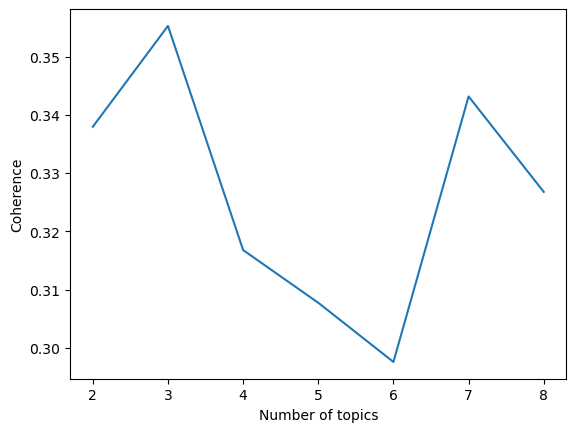

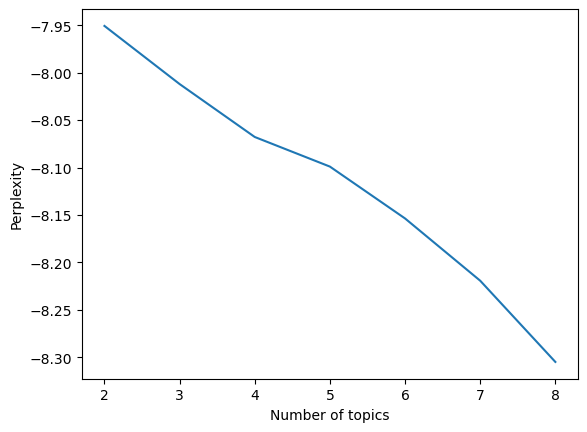

In [142]:
compute_coherence([i for i in data_media.T_text], 8)

100%|██████████| 19/19 [00:24<00:00,  1.31s/it]


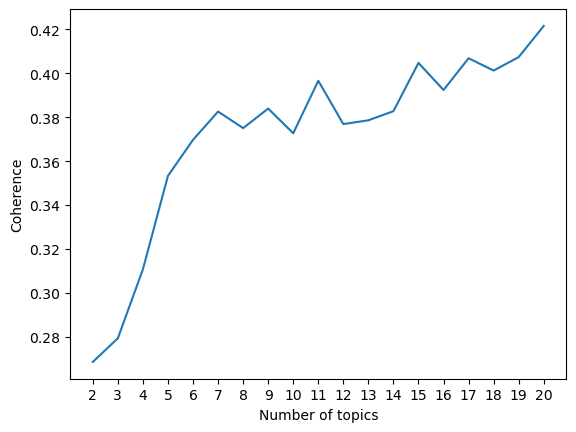

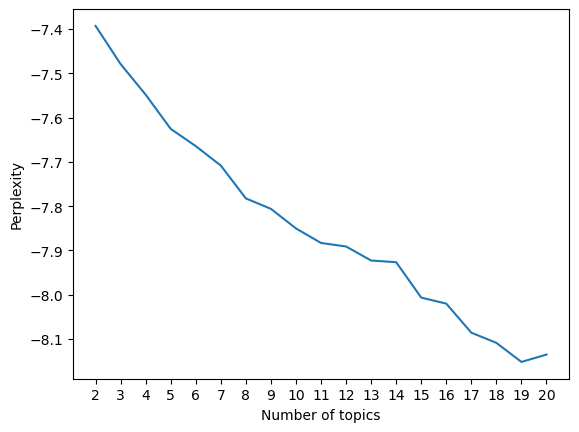

In [148]:
compute_coherence([i for i in data_govt.T_text], 20)

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
_pickle.UnpicklingError: pickle data was truncated
100%|██████████| 7/7 [01:51<00:00, 15.89s/it]


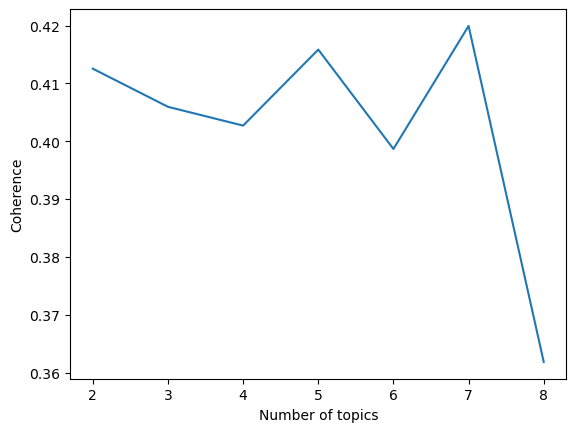

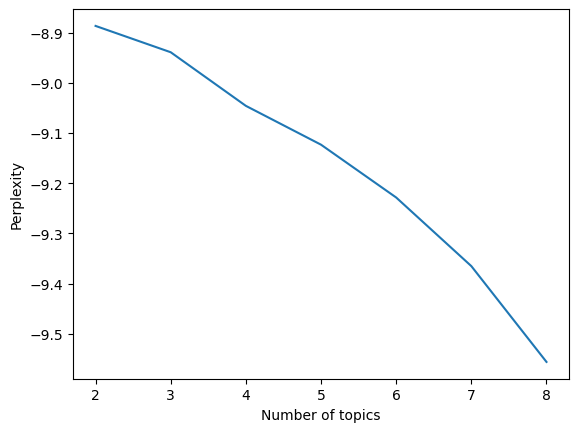

In [144]:
compute_coherence([i for i in data_people.T_text], 8)

In [93]:
# best model is 6
lda_model = LdaModel(corpus, num_topics=6, id2word=dictionary, random_state=1)
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

# Visualize the model with pyLDAvis
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [88]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.phrases import Phrases, Phraser
from nltk.tokenize import word_tokenize

# Define the list of strings
data = [i for i in data_people.T_text]

# Tokenize the strings
tokenized_data = [word_tokenize(text.lower()) for text in data]

# Create bigrams from the tokenized data
bigram_phrases = Phrases(tokenized_data)
bigram = Phraser(bigram_phrases)
tokenized_data_bigram = [bigram[text] for text in tokenized_data]

# Create a dictionary from the tokenized data
dictionary = corpora.Dictionary(tokenized_data_bigram)

# Convert the tokenized data into a bag of words
corpus = [dictionary.doc2bow(text) for text in tokenized_data_bigram]

# Define the range of number of topics to evaluate
min_topics, max_topics = 2, 6

# Iterate over the range of number of topics
for num_topics in range(min_topics, max_topics+1):

    # Train an LDA model with the current number of topics
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary)
    
    # Compute coherence for the current model
    coherence_model = CoherenceModel(model=lda_model, texts=tokenized_data_bigram, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model.get_coherence()
    
    # Print the coherence score for the current number of topics
    print(f"Coherence score for {num_topics} topics: {coherence}")


Coherence score for 2 topics: 0.3553067693078562
Coherence score for 3 topics: 0.3654568355104821
Coherence score for 4 topics: 0.3899242394178972
Coherence score for 5 topics: 0.3884568482767611
Coherence score for 6 topics: 0.42128301356191206


In [59]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk

# Sample text
text = [i for i in data_people.T_text]

# Tokenize on bigrams
bigram = CountVectorizer(tokenizer=lambda doc: nltk.ngrams(nltk.word_tokenize(doc.lower()), 2))
bigram_tokens = bigram.fit_transform(text)

# Train LDA model
lda_model = LatentDirichletAllocation(n_components=2)
lda_model.fit(bigram_tokens)


LatentDirichletAllocation(n_components=2)

In [60]:
from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(bigram, lda_model)
vis_data = pyLDAvis.sklearn.prepare(lda_model, bigram_tokens, bigram)
pyLDAvis.display(vis_data)

/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.vers

## people 4 topics

In [67]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk

# Sample text
text = [i for i in data_people.T_text]

# Tokenize on bigrams
bigram = CountVectorizer(tokenizer=lambda doc: nltk.ngrams(nltk.word_tokenize(doc.lower()), 2))
bigram_tokens = bigram.fit_transform(text)

# Train LDA model
lda_model = LatentDirichletAllocation(n_components=4)
lda_model.fit(bigram_tokens)

from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(bigram, lda_model)
vis_data = pyLDAvis.sklearn.prepare(lda_model, bigram_tokens, bigram)
pyLDAvis.display(vis_data)

/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.vers

In [ ]:
len(bigram.vocabulary_)

In [68]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk

# Sample text
text = [i for i in data_people.T_text]

# Tokenize on bigrams
bigram = CountVectorizer(tokenizer=lambda doc: nltk.ngrams(nltk.word_tokenize(doc.lower()), 3))
bigram_tokens = bigram.fit_transform(text)

# Train LDA model
lda_model = LatentDirichletAllocation(n_components=4)
lda_model.fit(bigram_tokens)

from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(bigram, lda_model)
vis_data = pyLDAvis.sklearn.prepare(lda_model, bigram_tokens, bigram)
pyLDAvis.display(vis_data)

/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use 

## Media, 4 tpics, trigrams


In [69]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk

# Sample text
text = [i for i in data_media.T_text]

# Tokenize on bigrams
bigram = CountVectorizer(tokenizer=lambda doc: nltk.ngrams(nltk.word_tokenize(doc.lower()), 3))
bigram_tokens = bigram.fit_transform(text)

# Train LDA model
lda_model = LatentDirichletAllocation(n_components=4)
lda_model.fit(bigram_tokens)

from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(bigram, lda_model)
vis_data = pyLDAvis.sklearn.prepare(lda_model, bigram_tokens, bigram)
pyLDAvis.display(vis_data)

/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use 

In [71]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk

# Sample text
text = [i for i in data_govt.T_text]

# Tokenize on bigrams
bigram = CountVectorizer(tokenizer=lambda doc: nltk.ngrams(nltk.word_tokenize(doc.lower()), 2))
bigram_tokens = bigram.fit_transform(text)

# Train LDA model
lda_model = LatentDirichletAllocation(n_components=4)
lda_model.fit(bigram_tokens)

from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(bigram, lda_model)
vis_data = pyLDAvis.sklearn.prepare(lda_model, bigram_tokens, bigram)
pyLDAvis.display(vis_data)

/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


# Until here, the rest need editing and deleting !!!

## cut

In [117]:
word1 = 'year'
word2 = 'team'

word1_column_idx = tf_vectorizer.vocabulary_[word1]
word2_column_idx = tf_vectorizer.vocabulary_[word2]

In [ ]:
np.array(tf.todense())

In [ ]:
tf[:, word1_column_idx].toarray()

In [ ]:
documents_with_word1 = (tf[:, word1_column_idx].toarray().flatten() > 0)

In [ ]:
documents_with_word2 = (tf[:, word2_column_idx].toarray().flatten() > 0)

In [ ]:
documents_with_both_word1_and_word2 = documents_with_word1 * documents_with_word2

In [ ]:
documents_with_both_word1_and_word2

Next, we compute the log of the conditional probability of word 1 appearing given that word 2 appeared, where we add in a little bit of a fudge factor in the numerator (in this case, it's actually not needed but some times you do have two words that do not co-occur for which you run into a numerical issue due to taking the log of 0).

In [ ]:
eps = 0.1
np.log2((documents_with_both_word1_and_word2.sum() + eps) / documents_with_word2.sum())

In [149]:
# compute log of prob of see one word given you see another, using count vectorizer!
# Same content as in hw , but with a different tool
# This uses np.arrays instead of counters. Needs to kep track of the indexes.
# Understad how countvectorizer works

def prob_see_word1_given_see_word2(word1, word2, vectorizer, eps=0.1):
    word1_column_idx = vectorizer.vocabulary_[word1]
    word2_column_idx = vectorizer.vocabulary_[word2]
    documents_with_word1 = (tf[:, word1_column_idx].toarray().flatten() > 0)
    documents_with_word2 = (tf[:, word2_column_idx].toarray().flatten() > 0)
    documents_with_both_word1_and_word2 = documents_with_word1 * documents_with_word2
    return np.log2((documents_with_both_word1_and_word2.sum() + eps) / documents_with_word2.sum())

In [ ]:
type(word1), type(word2)

## Topic coherence

The below code shows how one implements the topic coherence calculation from lecture.

In [ ]:
# In the cell below, vectorizer.get_feature_names() is just tokenizing the text, 
# eliminating stopwords, eliminating some other words, and then giving you back
# a list of the tokens in string format

In [150]:
# topic coherence

def compute_average_coherence(topic_word_distributions, num_top_words, vectorizer, verbose=True):
    vocab = vectorizer.get_feature_names()
    num_topics = len(topic_word_distributions)
    average_coherence = 0
    # foor loop thru different topics, for each topic double nested for loop, going thru each entry, ordering matters
    # make sure words arent the same, then compute the log(prob)
    # add a bunhc of them and divide by total number of topics
    for topic_idx in range(num_topics):
        if verbose:
            print('[Topic ', topic_idx, ']', sep='')
        
        sort_indices = np.argsort(topic_word_distributions[topic_idx])[::-1]
        coherence = 0.
        for top_word_idx1 in sort_indices[:num_top_words]:
            word1 = vocab[top_word_idx1]
            for top_word_idx2 in sort_indices[:num_top_words]:
                word2 = vocab[top_word_idx2]
                if top_word_idx1 != top_word_idx2:
                    coherence += prob_see_word1_given_see_word2(word1, word2, vectorizer, 0.1)
        
        if verbose:
            print('Coherence:', coherence)
            print()
        average_coherence += coherence
    average_coherence /= num_topics
    if verbose:
        print('Average coherence:', average_coherence)
    return average_coherence

In [151]:
num_top_words=10

In [152]:
compute_average_coherence(topic_word_distributions, num_top_words, tf_vectorizer, True)
# These are negative, the highest possible is zero.

[Topic 0]


/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


IndexError: list index out of range

## Number of unique words

The below code shows how one implements the number of unique words calculation from lecture.

In [95]:
# brute force implementation
# nothing clever to speed upmcalculation

#fro loop for each topic
# For loop over each top word
# another for loop for other topics
# lok for all other top words in those other topics
# check for uniqueness

def compute_average_num_unique_words(topic_word_distributions, num_top_words, vectorizer, verbose=True):
    vocab = vectorizer.get_feature_names()
    num_topics = len(topic_word_distributions)
    average_number_of_unique_top_words = 0
    for topic_idx1 in range(num_topics):
        if verbose:
            print('[Topic ', topic_idx1, ']', sep='')
        
        sort_indices1 = np.argsort(topic_word_distributions[topic_idx1])[::-1]
        num_unique_top_words = 0
        for top_word_idx1 in sort_indices1[:num_top_words]:
            word1 = vocab[top_word_idx1]
            break_ = False
            for topic_idx2 in range(num_topics):
                if topic_idx1 != topic_idx2:
                    sort_indices2 = np.argsort(topic_word_distributions[topic_idx2])[::-1]
                    for top_word_idx2 in sort_indices2[:num_top_words]:
                        word2 = vocab[top_word_idx2]
                        if word1 == word2:
                            break_ = True
                            break
                    if break_:
                        break
            else:
                num_unique_top_words += 1
        if verbose:
            print('Number of unique top words:', num_unique_top_words)
            print()

        average_number_of_unique_top_words += num_unique_top_words
    average_number_of_unique_top_words /= num_topics
    
    if verbose:
        print('Average number of unique top words:', average_number_of_unique_top_words)
    
    return average_number_of_unique_top_words

In [33]:
compute_average_num_unique_words(topic_word_distributions, num_top_words, tf_vectorizer, True)

[Topic 0]
Number of unique top words: 12

[Topic 1]
Number of unique top words: 18

[Topic 2]
Number of unique top words: 10

[Topic 3]
Number of unique top words: 11

[Topic 4]
Number of unique top words: 13

Average number of unique top words: 12.8


12.8

## Plotting average coherence vs k (number of topics), and average number of unique words vs k

Next, we plot the average coherence vs k and the average number of unique words vs k. Note that these are *not* the only topic model metrics available (much like how CH index is not the only metric available for clustering).

For both average coherence and average number of unique words, we would like these to be high. In this particular example, it turns out k=2 yields very high values for both but if you look at the topics learned for k=2, they are qualitatively quite bad (basically one topic is gibberish and the other is everything else!). This observation reinforces the important idea that while there exist topic modeling metrics (such as coherence and number of unique words), you should definitely still look at what the learned topics are (e.g., by printing the top words per topic) to help decide on what value of k to use.

Also, keep in mind that the results are in some sense "noisy" since the LDA fitting procedure is random. We're choosing a specific `random_state` seed value but if we try different random seeds, we can get different results. For simplicity, because LDA fitting is quite computationally expensive, we are *not* doing what we did with GMM's where we did many different random initializations. Thus, the conclusions we draw regarding how many topics to use might actually be different with different random initializations.

At least according to average coherence and average number of unique words for the random seed we use, the results below suggests that using k=4 yields average coherence and average number of unique words that are still reasonably high (as good as or almost as good as the k=2 result), and inspecting the topics learned for k=4, they are definitely more interesting than the ones learned for k=2.

From qualitatively looking at topics, the k=5, k=6, and k=7 topics also look decent. When k gets too large (e.g., k=10), there start to be topics that look like there might be too much overlap (such as multiple topics that seem to be about computers).

Note that one of the things to look out for is whether there are "stable" topics, where even for slightly different values of k and different random initializations, LDA keeps finding specific topics (e.g., one on gibberish, one on numbers, etc).

In [38]:
k_values = range(2, 10)
avg_coherences = []
avg_num_unique_words = []

for k in k_values:
    lda_candidate = LatentDirichletAllocation(n_components=k, random_state=0)
    lda_candidate.fit(tf)
    topic_word_distributions = np.array([row / row.sum() for row in lda_candidate.components_])
    print('-' * 80)
    print('Number of topics:', k)
    print()
    print_top_words(topic_word_distributions, num_top_words, tf_vectorizer)
    print()
    print()
    
    avg_coherences.append(compute_average_coherence(topic_word_distributions, num_top_words, tf_vectorizer, False))
    avg_num_unique_words.append(compute_average_num_unique_words(topic_word_distributions, num_top_words, tf_vectorizer, False))

--------------------------------------------------------------------------------
Number of topics: 2

Displaying the top 20 words per topic and their probabilities within the topic...

[Topic 0]
toxic : 0.018947190874659656
chemical : 0.0146115452622207
resident : 0.010830155655439894
epa : 0.007999680723243629
disaster : 0.006966187494212401
say : 0.006606448271329401
via : 0.006232089935997095
people : 0.005913273839575192
rail : 0.005855525932622772
ceo : 0.005576890298219318
week : 0.00526333465928172
crash : 0.005061909876325971
pay : 0.004480046732685991
water : 0.004477018407464085
town : 0.004397929397226687
site : 0.0042968358211493375
health : 0.004232030415188725
environmental : 0.004013384752745299
make : 0.003954174126354031
air : 0.003689459403823465

[Topic 1]
trump : 0.01634969760232949
derail : 0.015011308697711551
another : 0.011362601118430776
say : 0.010169433813758904
safety : 0.009975825059334477
biden : 0.009940841871689083
car : 0.009550665099861032
derails : 0.

Text(0, 0.5, 'Average coherence')

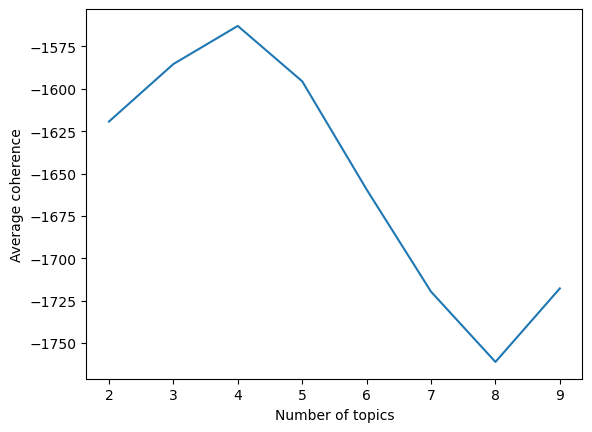

In [39]:
plt.plot(k_values, avg_coherences)
plt.xlabel('Number of topics')
plt.ylabel('Average coherence')

# For differnt number of topics, I fitted a different LDA



Text(0, 0.5, 'Average number of unique words')

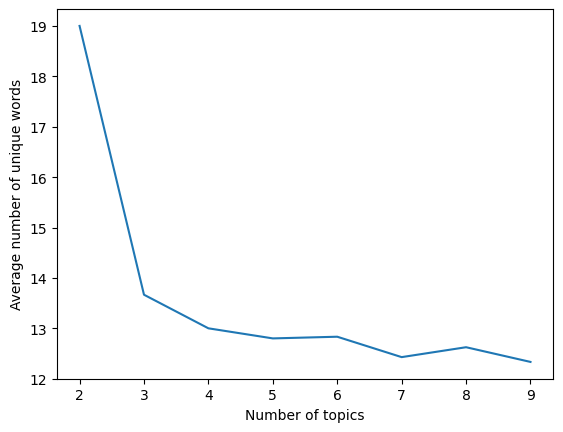

In [41]:
plt.plot(k_values, avg_num_unique_words)
plt.xlabel('Number of topics')
plt.ylabel('Average number of unique words')

# For different topic models, the average number of unique words
# We want coherence to be high and unique words to be high

# Number of topic = 2, gets me high coherence and hogh unique words. BUT, for model 2, there are 2 topics: garbage and not garbage!
# that doesnt help a lot

# So, you want to tolerate a lower value for one of the metrics, but look at the actual topics to interpret what is going on
# If we see resutlts of 4, starts to make more ssense but feels like still low
# go to 5, starts to make a bit more sense



# References
Evaluate Topic Models: Latent Dirichlet Allocation (LDA), available at https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [25]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [65]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(sample_data))

print(data_words[:1])

[['tristansnell', 'get', 'rid', 'safety', 'rule', 'get', 'get', 'rid', 'bank', 'safety', 'rule', 'get', 'svb', 'signature']]


In [66]:
data_lemmatized = data_words
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 4), (2, 2), (3, 2), (4, 2), (5, 1), (6, 1), (7, 1)]]


In [67]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [68]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.060*"north" + 0.039*"danger" + 0.022*"accident" + 0.019*"de" + '
  '0.016*"fire" + 0.015*"show" + 0.013*"last" + 0.013*"fox" + 0.012*"many" + '
  '0.012*"mile"'),
 (1,
  '0.021*"another" + 0.020*"derails" + 0.018*"say" + 0.016*"toxic" + '
  '0.016*"report" + 0.012*"company" + 0.012*"chemical" + 0.011*"epa" + '
  '0.011*"public" + 0.010*"resident"'),
 (2,
  '0.062*"derail" + 0.037*"carolina" + 0.034*"car" + 0.029*"via" + '
  '0.020*"cargo" + 0.019*"springfield" + 0.017*"time" + 0.016*"place" + '
  '0.016*"sign" + 0.016*"news"'),
 (3,
  '0.027*"trump" + 0.024*"safety" + 0.019*"would" + 0.016*"biden" + '
  '0.015*"rule" + 0.015*"regulation" + 0.014*"rail" + 0.012*"brake" + '
  '0.012*"go" + 0.010*"apply"')]


In [69]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.359154475447044

Coherence Score:  0.36541159788559885


In [74]:
lda_model

In [71]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/ribarragi/miniconda3/envs/Intro_AI/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/ribarragi/miniconda

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.341831 -0.172684       1        1  46.884871
3     -0.051284  0.366037       2        1  27.326682
2      0.218580 -0.147803       3        1  16.444026
0      0.174536 -0.045550       4        1   9.344421, topic_info=           Term          Freq         Total Category  logprob  loglift
118      derail  10784.000000  10784.000000  Default  30.0000  30.0000
2587      north   5922.000000   5922.000000  Default  29.0000  29.0000
2583   carolina   6340.000000   6340.000000  Default  28.0000  28.0000
354         car   5851.000000   5851.000000  Default  27.0000  27.0000
149       trump   7672.000000   7672.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
1614         la    517.892877    518.652872   Topic4  -5.2452   2.3689
923        care    598.881806    599.767014   Topic4  -5.0999   2.3689
32       damage    511.558984    512.366706   Topic4  -5.2575   2.3688
23727        le    493.086167    493.866106   Topic4  -5.2943   2.3688
2330       axle    518.421509    519.313233   Topic4  -5.2442   2.3687

[155 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
309       4  0.999707        accident
310       4  0.998163          accord
290       2  0.999456  administration
9481      1  0.535263             amp
9481      2  0.457742             amp
...     ...       ...             ...
208       3  0.999798             via
947       2  0.999286           waste
1304      3  0.999679           wheel
359       2  0.999760           would
231       1  0.999776            year

[134 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 1])

toxic : 0.022457791846392967
ceo : 0.01909519770061295
resident : 0.017347292501322095
chemical : 0.016160113157076755
epa : 0.013899063024322483
via : 0.009893960751737617
pay : 0.008269276069613581
say : 0.008163893554262587
senate : 0.008134594278846838
tell : 0.007605117286419225
congress : 0.006781515182579619
order : 0.006306676179334696
clean : 0.006226100852638858
rail : 0.0062106600464542985
crash : 0.006076923915123679
site : 0.005999986680991488
worker : 0.0059216764863732185
animal : 0.005689835953484064
company : 0.00549751936463235
demand : 0.005352323604188377

In [72]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [73]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

AttributeError: module 'gensim.models' has no attribute 'wrappers'

In [ ]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:

# Create Corpus
# texts = data_lemmatized

# Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]

# View
# print(corpus[:1][0][:30])